<a href="https://colab.research.google.com/github/yaazp/Visao-Computacional/blob/main/ProjetoFinal_OCR_e_OPENCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PREPARANDO O AMBIENTE**

In [2]:
#INSTALA BIBLIOTECAS
!pip install opencv-python==4.6.0.66 ####instalando tesseract e libs complementares
!sudo apt install tesseract-ocr
!pip install pytesseract==0.3.9

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 16.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.8.0.76
    Uninstalling opencv-python-4.8.0.76:
      Successfully uninstalled opencv-python-4.8.0.76
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 33 not upgraded.
Need to get 0 B/4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 3.)
debconf: falling back to frontend: Readline
debconf: unable

In [3]:
#COPIA ARQUIVOS GIT
! git clone https://github.com/sthemonica/text-recognize

Cloning into 'text-recognize'...
remote: Enumerating objects: 148, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 148 (delta 3), reused 1 (delta 1), pack-reused 144
Receiving objects: 100% (148/148), 37.21 MiB | 31.10 MiB/s, done.
Resolving deltas: 100% (35/35), done.


In [4]:
#IMPORTA BIBLIOTECAS
import pytesseract
import numpy as np
import cv2
import re
import os
import matplotlib.pyplot as plt

from PIL import ImageFont, ImageDraw, Image
from pytesseract import Output
from google.colab.patches import cv2_imshow


In [6]:
#VALIDA VERSÃO 1
pytesseract.__version__

'0.3.9'

In [7]:
#VALIDA VERSÃO 2
cv2.__version__


'4.6.0'

In [8]:
#CRIA PASTA COM IDIOMA E CLONA ARQUIVO DO GIT
!mkdir tessdata
!wget -O ./tessdata/por.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true
!wget -O ./tessdata/eng.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/eng.traineddata?raw=true


--2024-02-16 21:04:37--  https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/tesseract-ocr/tessdata/raw/main/por.traineddata [following]
--2024-02-16 21:04:37--  https://github.com/tesseract-ocr/tessdata/raw/main/por.traineddata
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tesseract-ocr/tessdata/main/por.traineddata [following]
--2024-02-16 21:04:37--  https://raw.githubusercontent.com/tesseract-ocr/tessdata/main/por.traineddata
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awa

# **ENTENDENDO OS DADOS**

In [39]:
#CONCATENA TODAS AS IMAGENS PARA QUE AS BUSCAS SEJAM FEITAS DE FORMA SIMULTÂNEA
projeto = "/content/text-recognize/Imagens/Projeto"
caminho = [os.path.join(projeto, f) for f in os.listdir(projeto)]
print(caminho)


['/content/text-recognize/Imagens/Projeto/artigo-termos-ML.png', '/content/text-recognize/Imagens/Projeto/artigo-spark.png', '/content/text-recognize/Imagens/Projeto/artigo-eng-dados.png', '/content/text-recognize/Imagens/Projeto/artigo-desbalanceamento.png']


In [11]:
#CRIA FUNÇÃO PARA MOSTRAR AS IMAGENS COM A BIBLIOTECA MATPLOTLIB
def mostrar(img):
  fig = plt.gcf() # busca a figura atual
  fig.set_size_inches(20, 10) #define o tamanho
  plt.axis("off") #remove a visualização dos eixos
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #faz a conversão de cores com o OpenCV
  plt.show() # mostra a imagem


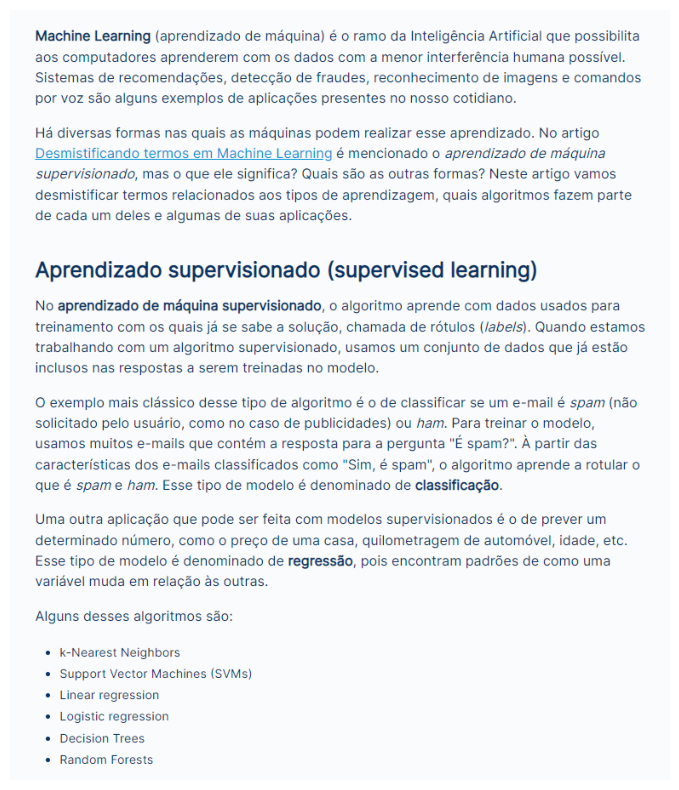

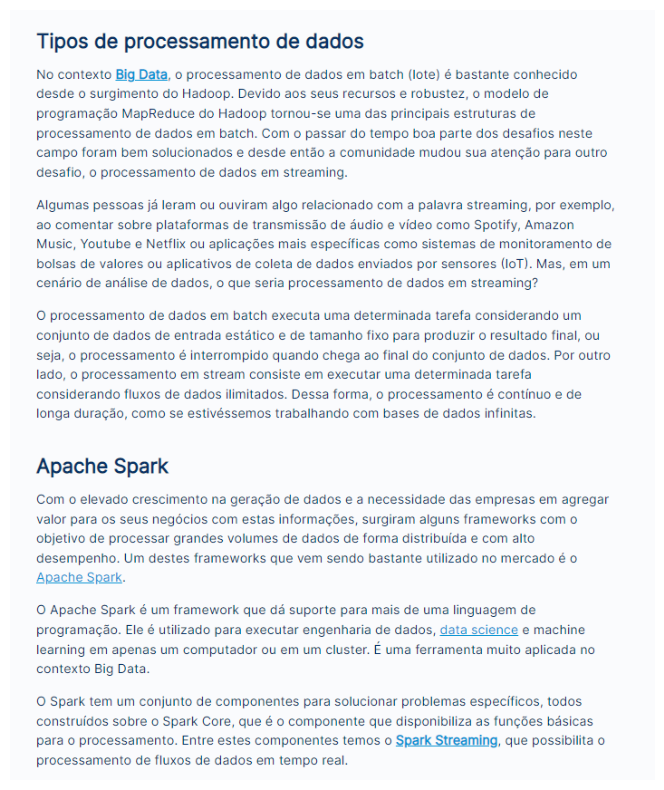

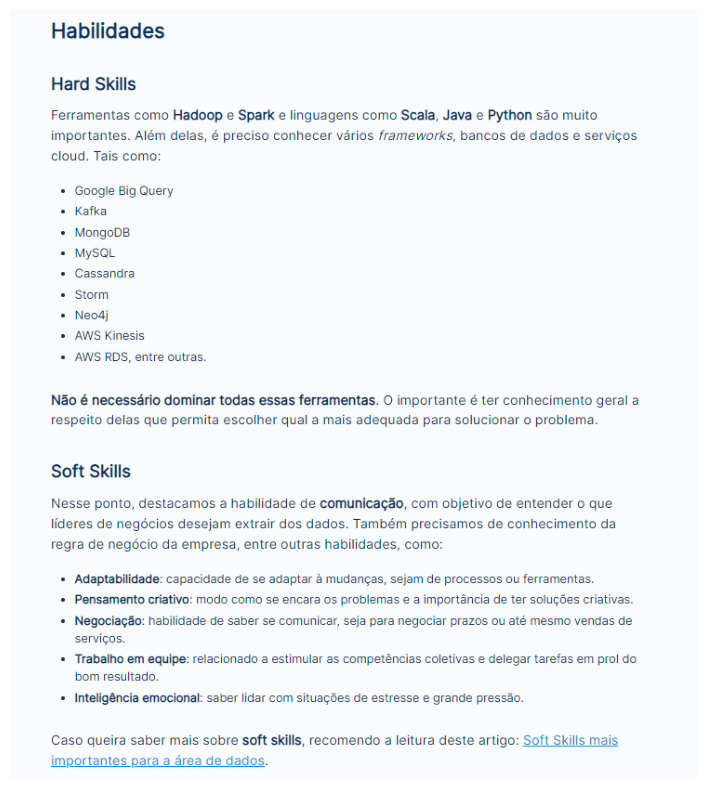

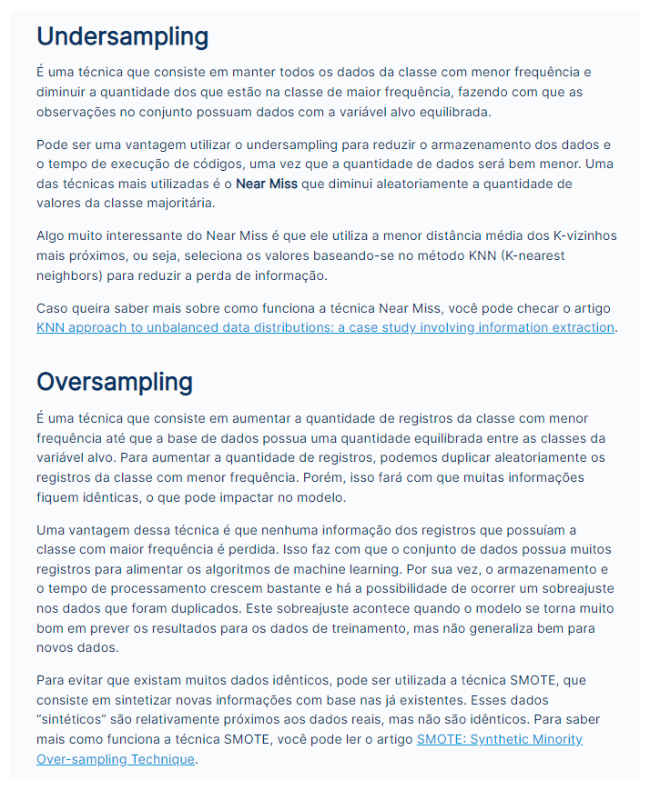

In [12]:
#MOSTRAR IMAGENS
for imagem in caminho:
  imagem = cv2.imread(imagem)
  mostrar(imagem)


In [13]:
##comando para poder identificar os modos de psm da biblioteca
!tesseract --help-psm

Page segmentation modes:
  0    Orientation and script detection (OSD) only.
  1    Automatic page segmentation with OSD.
  2    Automatic page segmentation, but no OSD, or OCR. (not implemented)
  3    Fully automatic page segmentation, but no OSD. (Default)
  4    Assume a single column of text of variable sizes.
  5    Assume a single uniform block of vertically aligned text.
  6    Assume a single uniform block of text.
  7    Treat the image as a single text line.
  8    Treat the image as a single word.
  9    Treat the image as a single word in a circle.
 10    Treat the image as a single character.
 11    Sparse text. Find as much text as possible in no particular order.
 12    Sparse text with OSD.
 13    Raw line. Treat the image as a single text line,
       bypassing hacks that are Tesseract-specific.


In [15]:
#CRIA UMA FUNÇÃO PARA PODER LER O TEXTO DE FORMA MAIS EFICIÊNTE
config_tesseract = "--tessdata-dir tessdata"

def OCR_processa(img, config_tesseract):
  texto = pytesseract.image_to_string(img, lang='por', config=config_tesseract)
  return texto


# **RECONHECIMENTO DE TEXTO**

In [40]:
#CRIA 2 VARIÁVEIS NOVA PARA CONCATENAR TEXTOS E SALVAR O RESULTAODO EM TXT
texto_completo = ''
nome_txt = 'resultados_ocr.txt'

In [41]:
#CRIA A ITERAÇÃO DA EXTRAÇÃO DO TEXTO DAS IMAGENS
for imagem in caminho: # percorre as imagens no caminho
  img = cv2.imread(imagem)
  nome_imagem = os.path.split(imagem)[-1] ## recebe os nomes e diretórios das imagens, quebrados, precisamos apenas do -1 (última posição do diretório)
  nome_divisao = '===================\n' + str(nome_imagem) #divisão + nome da imagem que está sendo vista
  texto_completo = texto_completo + nome_divisao + '\n' # recebe o texto completo + a divisão + /n para pular a linha
  texto = OCR_processa(img, config_tesseract) #passa a imagem que vamos utilizar, no caso em cada imagem
  texto_completo = texto_completo + texto # concatena as duas variáveis


In [42]:
#VERIFICA O QUE FOI EXTRAÍDO
texto_completo

'===================\nartigo-termos-ML.png\nMachine Learning (aprendizado de máquina) é o ramo da Inteligência Artificial que possibilita\naos computadores aprenderem com os dados com a menor interferência humana possível.\nSistemas de recomendações, detecção de fraudes, reconhecimento de imagens e comandos\npor voz são alguns exemplos de aplicações presentes no nosso cotidiano.\n\nHá diversas formas nas quais as máquinas podem realizar esse aprendizado. No artigo\nDesmistificando termos em Machine Learning é mencionado o aprendizado de máquina\nsupervisionado, mas o que ele significa? Quais são as outras formas? Neste artigo vamos\ndesmistificar termos relacionados aos tipos de aprendizagem, quais algoritmos fazem parte\nde cada um deles e algumas de suas aplicações.\n\nAprendizado supervisionado (supervised learning)\n\nNo aprendizado de máquina supervisionado, o algoritmo aprende com dados usados para\n\ntreinamento com os quais já se sabe a solução, chamada de rótulos (/abels). Qua

In [43]:
#SALVA O RESULTADO EM TXT
arquivo_txt = open(nome_txt, 'w+') # a+ é para colocar no final do arquivo, w+ para sobre escrever o arquivo
arquivo_txt.write(texto_completo + '\n') #passa o texto que quer adicionar
arquivo_txt.close()


# **BUSCA POR OCORRÊNCIA**

In [44]:
#BUSCA POR UM TERMO DE PESQUISA
termo_pesquisa = 'learning'

In [45]:
#UTILIZA A BIBLIOTECA RE PARA FAZER A BUSCA
with open(nome_txt) as f: #abre o documento
  ocorrencias = [i.start() for i in re.finditer(termo_pesquisa, f.read())] #busca as ocorrências do termo na string
  #inicia-se em i e o termo re é de expressões regulares, o módulo finditer é
  #para encontrar um termo de pesquisa dentro do arquivo
  #por isso os parâmetros são, respectivamente, termo_pesquisa e arquivo a ser lido.

In [46]:
#VERIFICA AS OCORRÊNCIAS -> retorna a posição da ocorrência
ocorrencias

[807, 4006, 7490]

In [23]:
#PERCORRE AS IMAGENS E DEMONSTRA DE UMA FORMA MELHOR AS OCORRÊNCIAS
for imagem in caminho:
  img = cv2.imread(imagem) #carrega a imagem
  nome_imagem = os.path.split(imagem)[-1] # passa a imagem e acessa a última posição do diretório
  print('====================\n' + str(nome_imagem)) # separação + nome da imagem

  texto = OCR_processa(img, config_tesseract) #usando o OCR

  ocorrencias = [i.start() for i in re.finditer(termo_pesquisa, texto)] #usando o finditer novamente no texto

  print('Número de ocorrências para o termo: {}: {}'.format(termo_pesquisa, len(ocorrencias)))
  #primeira chaves é para termo de pesquisa e a segunda é para ocorrencias
  print('\n')




artigo-termos-ML.png
Número de ocorrências para o termo: learning: 1


artigo-spark.png
Número de ocorrências para o termo: learning: 1


artigo-eng-dados.png
Número de ocorrências para o termo: learning: 0


artigo-desbalanceamento.png
Número de ocorrências para o termo: learning: 1




# **ATIVIDADE EXTRA - REALIZANDO O MESMO PASSO A PASSO PARA IMAGENS DA PASTA AULA 5 - TERMO BUSCA: AMBIENTE**

In [25]:
#1 - CONCATENA TODAS AS IMAGENS PARA QUE AS BUSCAS SEJAM FEITAS DE FORMA SIMULTÂNEA
projeto = "/content/text-recognize/Atividades/Aula 5"
caminho = [os.path.join(projeto, f) for f in os.listdir(projeto)]
print(caminho)


['/content/text-recognize/Atividades/Aula 5/Aula5-GitHub.png', '/content/text-recognize/Atividades/Aula 5/Aula5-Ambientes_Virtuais.png', '/content/text-recognize/Atividades/Aula 5/Aula5-Microstrategy.png', '/content/text-recognize/Atividades/Aula 5/Aula5-Visao.png', '/content/text-recognize/Atividades/Aula 5/Aula5-ROC.png']


USAR FUNÇÃO DE MOSTRAR IMAGENS QUE JÁ ESTÁ PRONTA

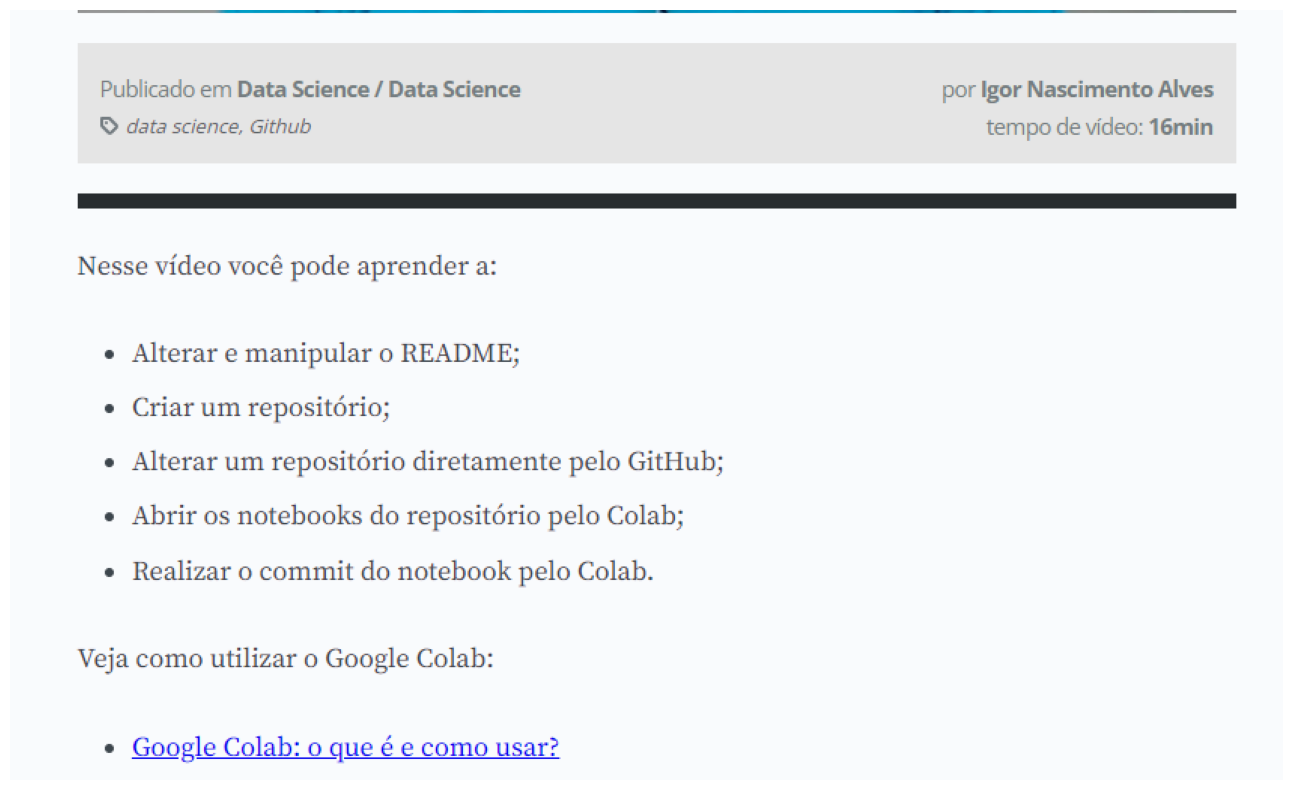

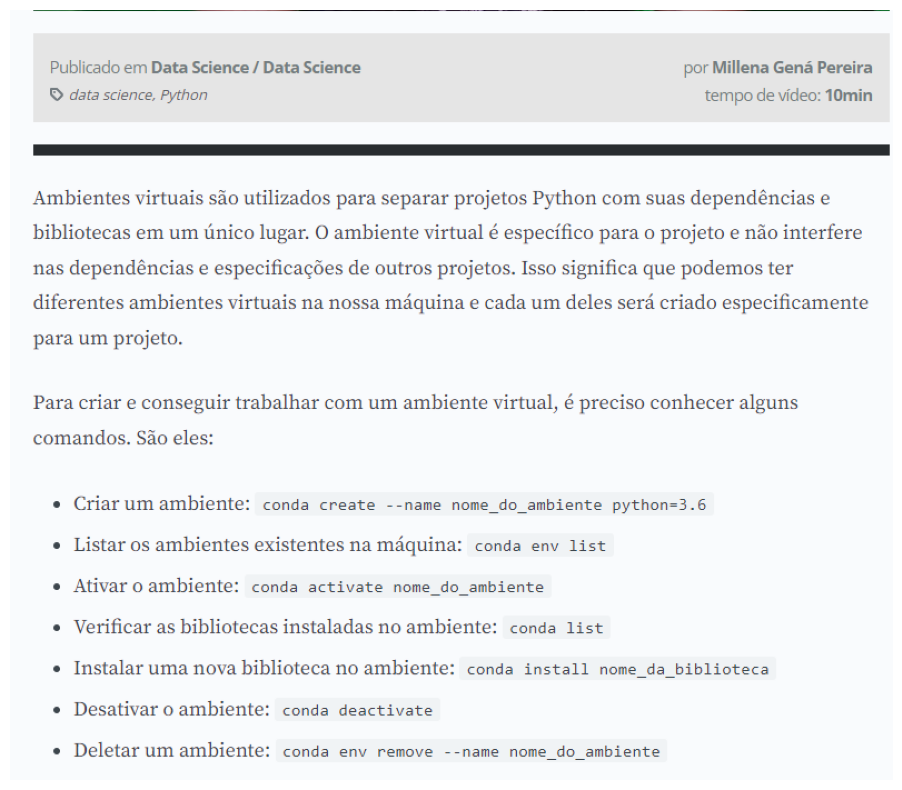

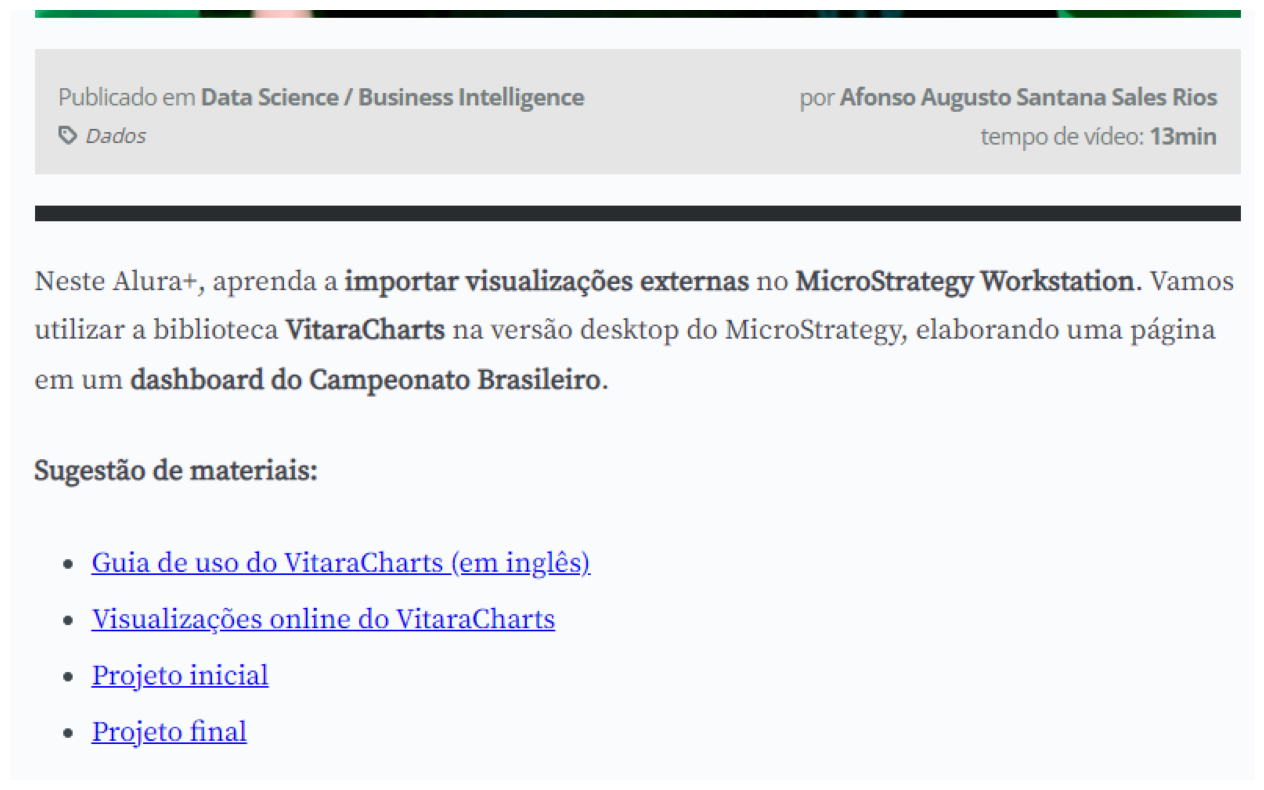

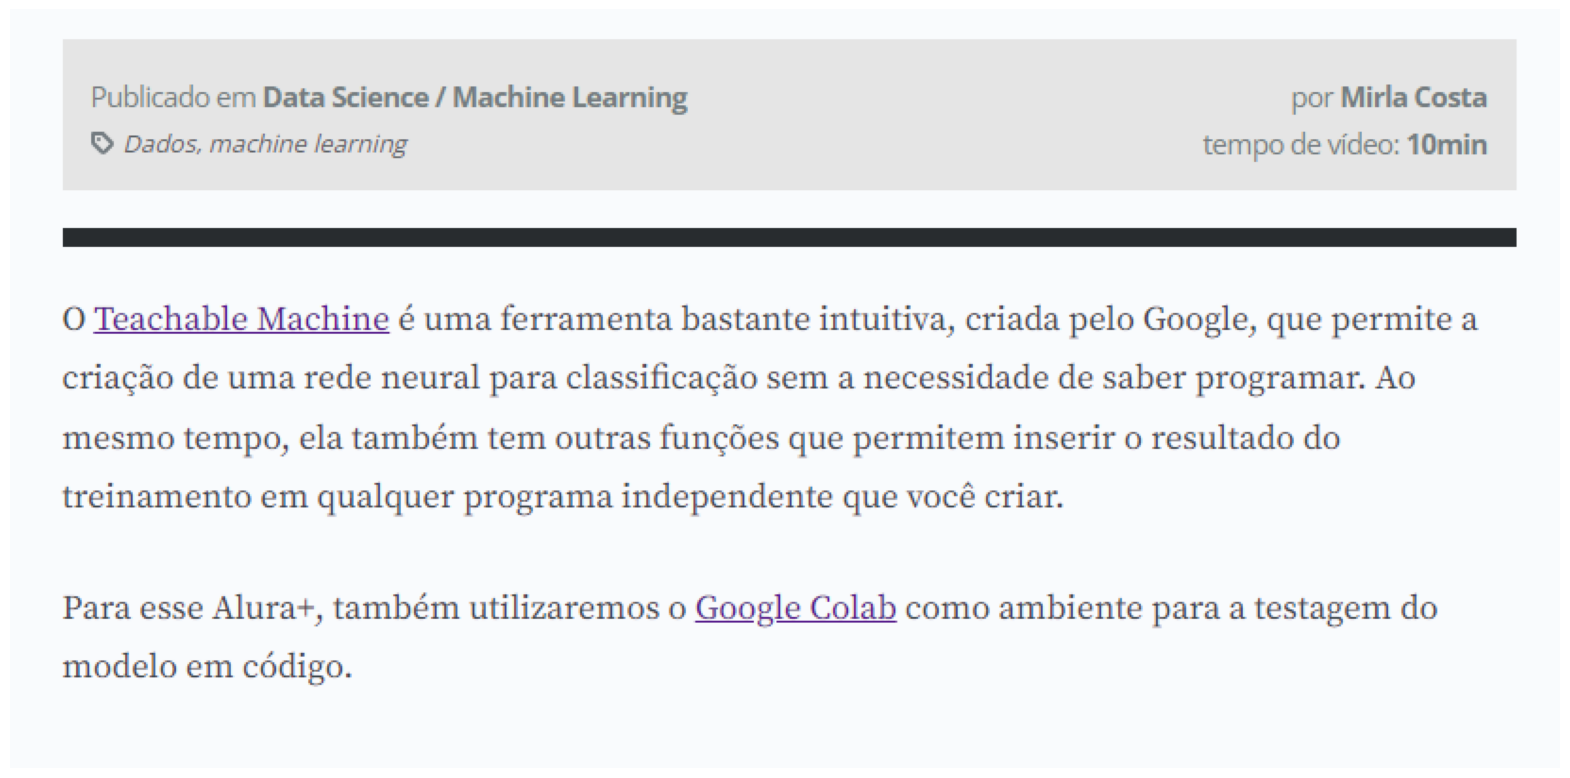

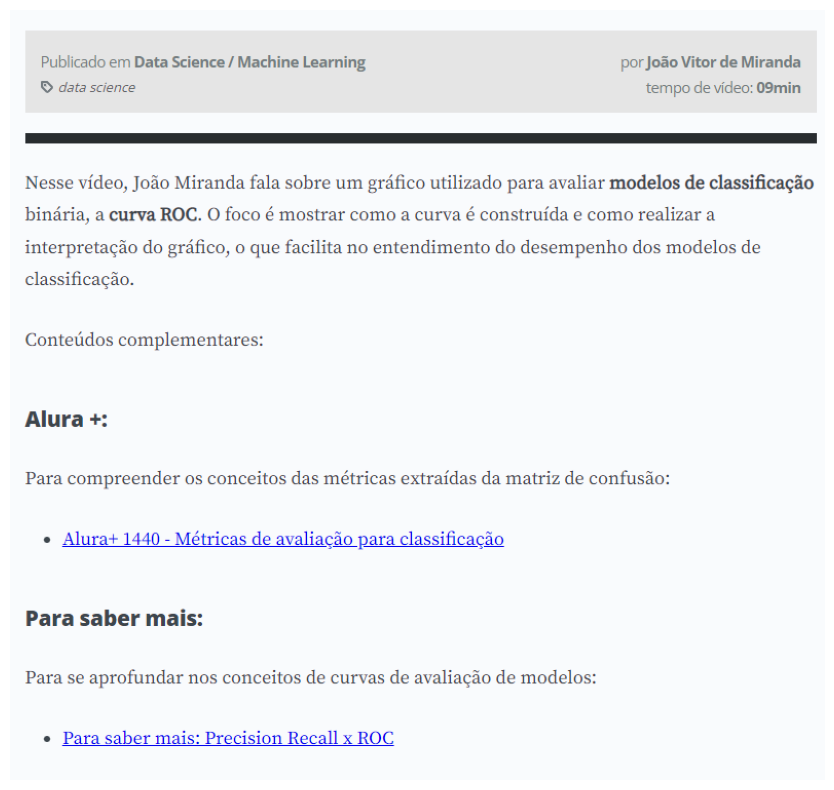

In [26]:
#3 - MOSTRAR IMAGENS
for imagem in caminho:
  imagem = cv2.imread(imagem)
  mostrar(imagem)


USAR FUNÇÃO DE LER OCR QUE JÁ ESTÁ PRONTA

In [31]:
#5 - CRIA 2 VARIÁVEIS NOVA PARA CONCATENAR TEXTOS E SALVAR O RESULTAODO EM TXT
texto_completo = ''
nome_txt = 'resultados_ocr_atividade.txt'

In [32]:
#6 - CRIA A ITERAÇÃO DAS IMEGENS
for imagem in caminho: # percorre as imagens no caminho
  img = cv2.imread(imagem)
  nome_imagem = os.path.split(imagem)[-1] ## recebe os nomes e diretórios das imagens, quebrados, precisamos apenas do -1 (última posição do diretório)
  nome_divisao = '===================\n' + str(nome_imagem) #divisão + nome da imagem que está sendo vista
  texto_completo = texto_completo + nome_divisao + '\n' # recebe o texto completo + a divisão + /n para pular a linha
  texto = OCR_processa(img, config_tesseract) #passa a imagem que vamos utilizar, no caso em cada imagem
  texto_completo = texto_completo + texto # concatena as duas variáveis

In [29]:
#7 - VERIFICA O QUE FOI EXTRAÍDO
texto_completo

"===================\nAula5-GitHub.png\n \n\nPublicado em Data Science / Data Science por Igor Nascimento Alves\nE data science, Github tempo de vídeo: 16min\n\nNesse vídeo você pode aprender a:\n\nAlterar e manipular o README;\n\nCriar um repositório;\n\nAlterar um repositório diretamente pelo GitHub;\n\nAbrir os notebooks do repositório pelo Colab;\n\nRealizar o commit do notebook pelo Colab.\n\nVeja como utilizar o Google Colab:\n\n* Google Colab: o que é e como usar?\n\n \n\x0c===================\nAula5-Ambientes_Virtuais.png\n \n\nPublicado em Data Science / Data Science por Millena Gená Pereira\n/ data science, Python tempo de vídeo: 10min\n\nAmbientes virtuais são utilizados para separar projetos Python com suas dependências e\nbibliotecas em um único lugar. O ambiente virtual é específico para o projeto e não interfere\nnas dependências e especificações de outros projetos. Isso significa que podemos ter\ndiferentes ambientes virtuais na nossa máquina e cada um deles será criado

In [33]:
#8 - SALVA O RESULTADO EM TXT
arquivo_txt = open(nome_txt, 'w+') # a+ é para colocar no final do arquivo, w+ para sobre escrever o arquivo
arquivo_txt.write(texto_completo + '\n') #passa o texto que quer adicionar
arquivo_txt.close()

In [34]:
#9 - BUSCA POR UM TERMO DE PESQUISA
termo_pesquisa = 'ambiente'

In [35]:
#10 - UTILIZA A BIBLIOTECA RE PARA FAZER A BUSCA
with open(nome_txt) as f: #abre o documento
  ocorrencias = [i.start() for i in re.finditer(termo_pesquisa, f.read())] #busca as ocorrências do termo na string
  #inicia-se em i e o termo re é de expressões regulares, o módulo finditer é
  #para encontrar um termo de pesquisa dentro do arquivo
  #por isso os parâmetros são, respectivamente, termo_pesquisa e arquivo a ser lido.

In [36]:
#11 - VERIFICA AS OCORRÊNCIAS -> retorna a posição da ocorrência
ocorrencias

[742,
 899,
 1038,
 1120,
 1158,
 1188,
 1247,
 1280,
 1331,
 1387,
 1444,
 1485,
 1527,
 2586]

In [37]:
#12 - PERCORRE AS IMAGENS E DEMONSTRA DE UMA FORMA MELHOR AS OCORRÊNCIAS
for imagem in caminho:
  img = cv2.imread(imagem) #carrega a imagem
  nome_imagem = os.path.split(imagem)[-1] # passa a imagem e acessa a última posição do diretório
  print('====================\n' + str(nome_imagem)) # separação + nome da imagem

  texto = OCR_processa(img, config_tesseract) #usando o OCR

  ocorrencias = [i.start() for i in re.finditer(termo_pesquisa, texto)] #usando o finditer novamente no texto

  print('Número de ocorrências para o termo: {}: {}'.format(termo_pesquisa, len(ocorrencias)))
  #primeira chaves é para termo de pesquisa e a segunda é para ocorrencias
  print('\n')

Aula5-GitHub.png
Número de ocorrências para o termo: ambiente: 0


Aula5-Ambientes_Virtuais.png
Número de ocorrências para o termo: ambiente: 13


Aula5-Microstrategy.png
Número de ocorrências para o termo: ambiente: 0


Aula5-Visao.png
Número de ocorrências para o termo: ambiente: 1


Aula5-ROC.png
Número de ocorrências para o termo: ambiente: 0




# **RECONHECIMENTO NA IMAGEM**

In [47]:
#1 - IMPORTA A FONTE
fonte_dir = '/content/text-recognize/Imagens/calibri.ttf'

In [48]:
#2 - FUNLÇÃO PARA ESCREVER TEXTO
def escreve_texto(texto, x, y, img, fonte_dir, cor=(50, 50, 255), tamanho=16):
  fonte = ImageFont.truetype(fonte_dir, tamanho)
  img_pil = Image.fromarray(img)
  draw = ImageDraw.Draw(img_pil)
  draw.text((x, y-tamanho), texto, font = fonte, fill = cor)
  img = np.array(img_pil)

  return img

In [49]:
#3 - DEFINE O MÍNIMO DE CONFIANÇA
min_conf = 30  #@param {type:"slider", min:0, max:100}

In [50]:
#4 - FUNÇÃO PARA CRIAR CAIXAS DE TEXTO
def caixa_texto(i, resultado, img, cor=(255, 100, 0)):
  x = resultado["left"][i]
  y = resultado["top"][i]
  w = resultado["width"][i]
  h = resultado["height"][i]

  cv2.rectangle(img, (x, y), (x + w, y + h), cor, 2)

  return x, y, img

In [52]:
#5 - FUNÇÃO OCR PARA PROCESSAR A IMAGEM
def OCR_processa_imagem(img, termo_pesquisa, config_tesseract, min_conf):
  resultado = pytesseract.image_to_data(img, config=config_tesseract, lang='por', output_type=Output.DICT) #transforma a imagem para dados, que já fizemos anteriormente
  num_ocorrencias = 0 #inicializando como 0

  for i in range(0, len(resultado['text'])): # vai de 0 ao tamanho do número de valores do texto
    confianca = int(resultado['conf'][i]) # qual a confiança da detecção - baseado em i porque temos mais de uma imagem
    if confianca > min_conf: # se a confiança for maior que o valor mínimo, passa para a linha abaixo
      texto = resultado['text'][i] #texto será igual ao resultado text no momento i
      if termo_pesquisa in texto: #se o termo de pesquisa estiver no texto:
        x, y, img = caixa_texto(i, resultado, img, (0,0,255)) # faz a caixa de bounding box
        img = escreve_texto(texto, x, y, img, fonte_dir, (50,50,225), 14) #escreve o texto

        num_ocorrencias += 1 #faz a iteração no num de ocorrências e volta para o laço até acabar o texto
  return img, num_ocorrencias


artigo-termos-ML.png
Número de ocorrências para learning em artigo-termos-ML.png: 1




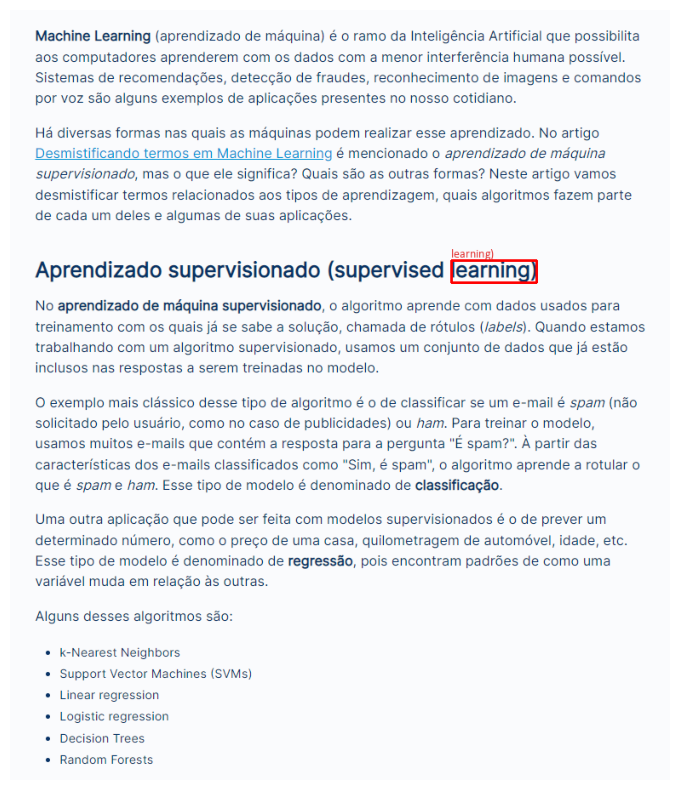

artigo-spark.png
Número de ocorrências para learning em artigo-spark.png: 1




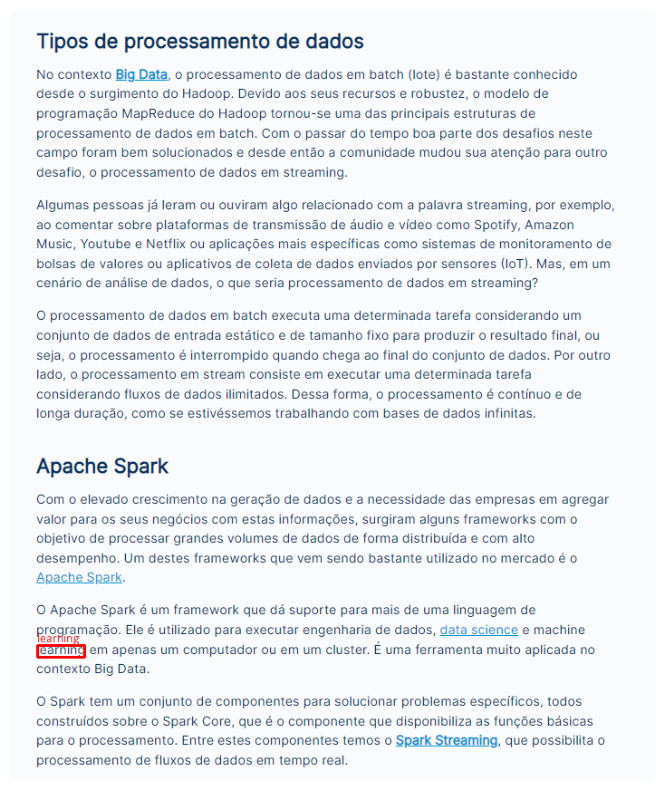

artigo-eng-dados.png
Número de ocorrências para learning em artigo-eng-dados.png: 0




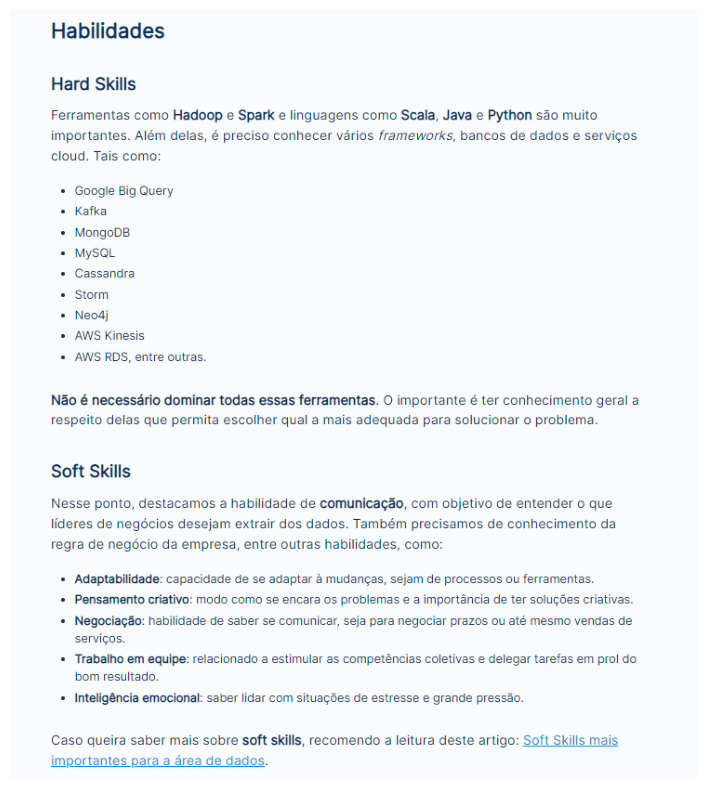

artigo-desbalanceamento.png
Número de ocorrências para learning em artigo-desbalanceamento.png: 1




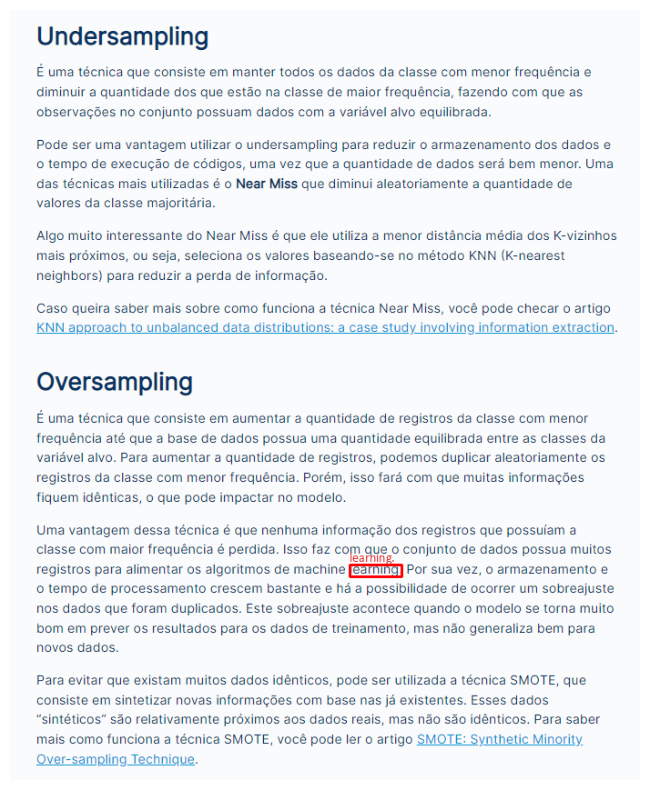

In [53]:
#6 - BUSCA O TERMO DE PESQUISA NAS IMAGENS
termo_pesquisa = 'learning'

for imagem in caminho:
  img = cv2.imread(imagem) #carrega a imagem
  img_original = img.copy() #cria uma cópia da imagem para não escrever em cima da original

  nome_imagem = os.path.split(imagem)[-1] # passa a imagem e acessa a última posição do diretório
  print('===================\n' + str(nome_imagem))  # separação + nome da imagem

  img, numero_ocorrencias = OCR_processa_imagem(img, termo_pesquisa, config_tesseract, min_conf) #usando o OCR_processa_imagem
  print('Número de ocorrências para {} em {}: {}'.format(termo_pesquisa, nome_imagem, numero_ocorrencias))
    #primeira chaves é para termo de pesquisa e a segunda nome das imagens e a terceira é o numeros de ocorrencias
  print('\n')

  mostrar(img)


In [54]:
#7 - FUNÇÃO OCR PARA PROCESSAR A IMAGEM - v2 (TRATAMENTO MAIÚSCULO/MINÚSCULO)
def OCR_processa_imagem(img, termo_pesquisa, config_tesseract, min_conf):
  resultado = pytesseract.image_to_data(img, config=config_tesseract, lang='por', output_type=Output.DICT) #transforma a imagem para dados, que já fizemos anteriormente
  num_ocorrencias = 0 #inicializando como 0

  for i in range(0, len(resultado['text'])): # vai de 0 ao tamanho do número de valores do texto
    confianca = int(resultado['conf'][i]) # qual a confiança da detecção - baseado em i porque temos mais de uma imagem
    if confianca > min_conf: # se a confiança for maior que o valor mínimo, passa para a linha abaixo
      texto = resultado['text'][i] #texto será igual ao resultado text no momento i
      if termo_pesquisa.lower() in texto.lower(): #se o termo de pesquisa estiver no texto: --> lower() para deixar ambos os lados em caixa baixa
        x, y, img = caixa_texto(i, resultado, img, (0,0,255)) # faz a caixa de bounding box
        img = escreve_texto(texto, x, y, img, fonte_dir, (50,50,225), 14) #escreve o texto

        num_ocorrencias += 1 #faz a iteração no num de ocorrências e volta para o laço até acabar o texto
  return img, num_ocorrencias


artigo-termos-ML.png
Número de ocorrências para learning em artigo-termos-ML.png: 3




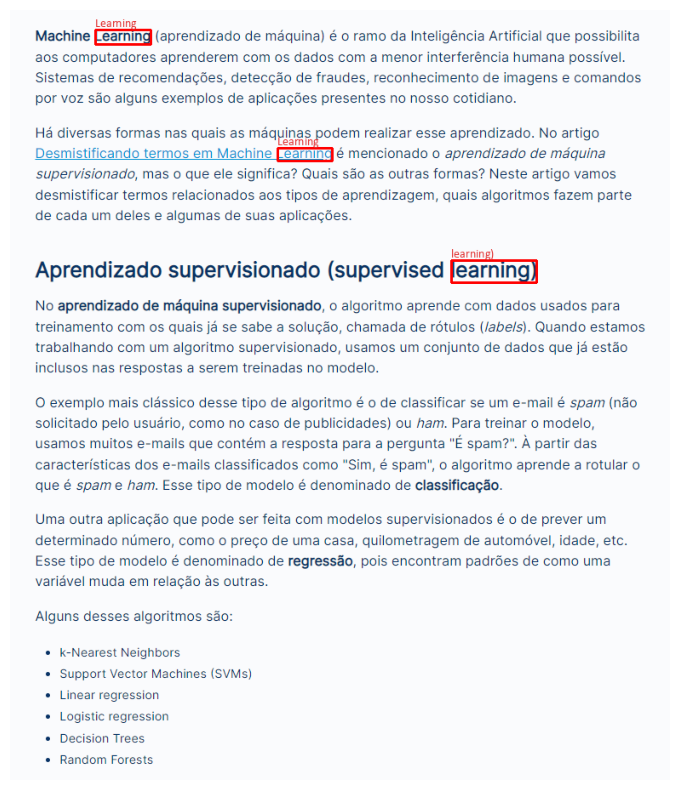

artigo-spark.png
Número de ocorrências para learning em artigo-spark.png: 1




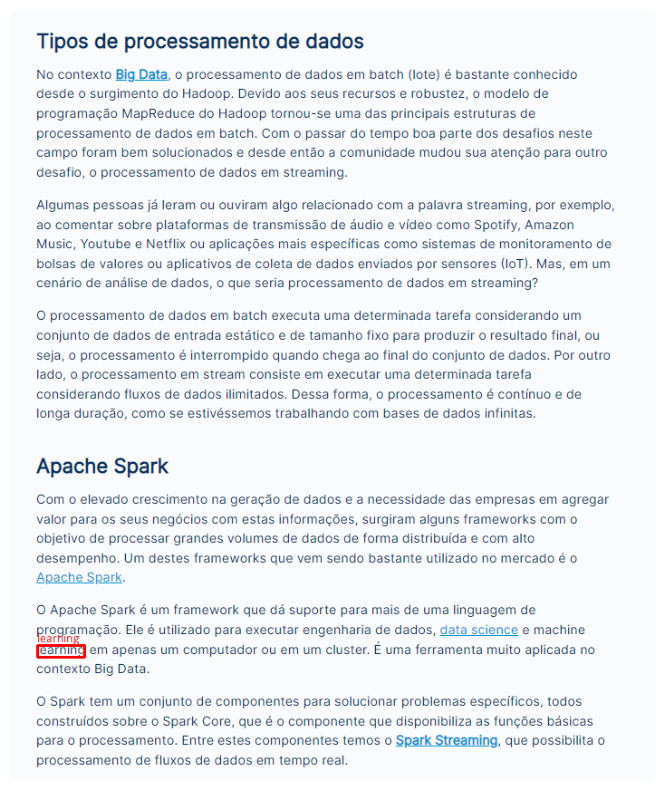

artigo-eng-dados.png
Número de ocorrências para learning em artigo-eng-dados.png: 0




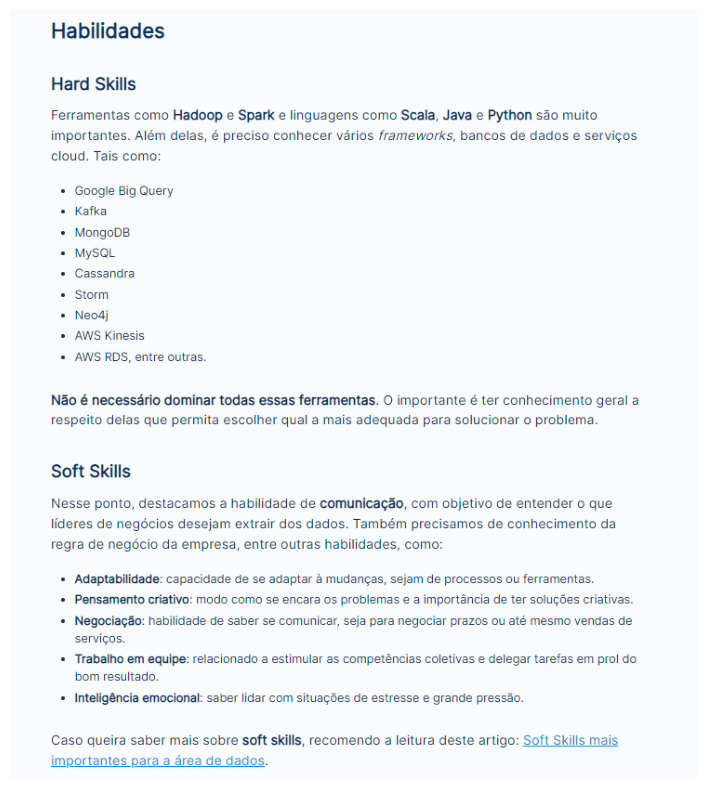

artigo-desbalanceamento.png
Número de ocorrências para learning em artigo-desbalanceamento.png: 1




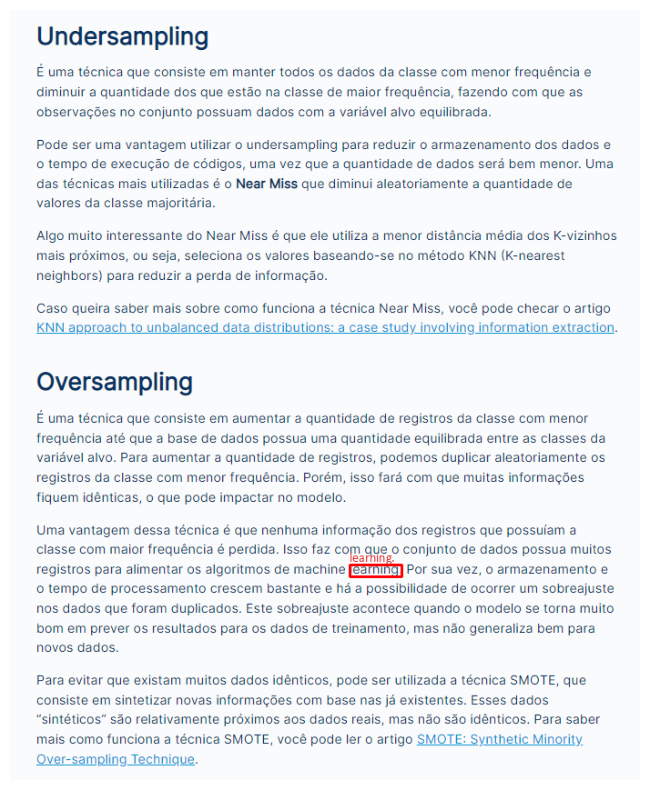

In [55]:
#8 - BUSCA O TERMO DE PESQUISA NAS IMAGENS - v2
termo_pesquisa = 'learning'

for imagem in caminho:
  img = cv2.imread(imagem) #carrega a imagem
  img_original = img.copy() #cria uma cópia da imagem para não escrever em cima da original

  nome_imagem = os.path.split(imagem)[-1] # passa a imagem e acessa a última posição do diretório
  print('===================\n' + str(nome_imagem))  # separação + nome da imagem

  img, numero_ocorrencias = OCR_processa_imagem(img, termo_pesquisa, config_tesseract, min_conf) #usando o OCR_processa_imagem
  print('Número de ocorrências para {} em {}: {}'.format(termo_pesquisa, nome_imagem, numero_ocorrencias))
    #primeira chaves é para termo de pesquisa e a segunda nome das imagens e a terceira é o numeros de ocorrencias
  print('\n')

  mostrar(img)

In [56]:
#9 - CRIA DIRETÓRIO PARA IMAGENS COM CORRESPONDÊNCIA
import os
os.makedirs('images_project', exist_ok=True)

artigo-termos-ML.png
Número de ocorrências para learning em artigo-termos-ML.png: 3


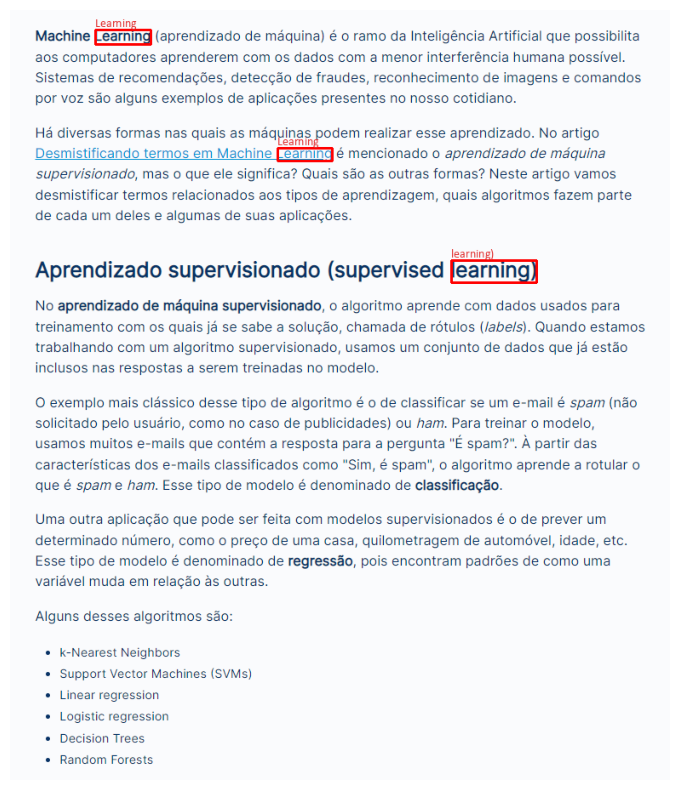



artigo-spark.png
Número de ocorrências para learning em artigo-spark.png: 1


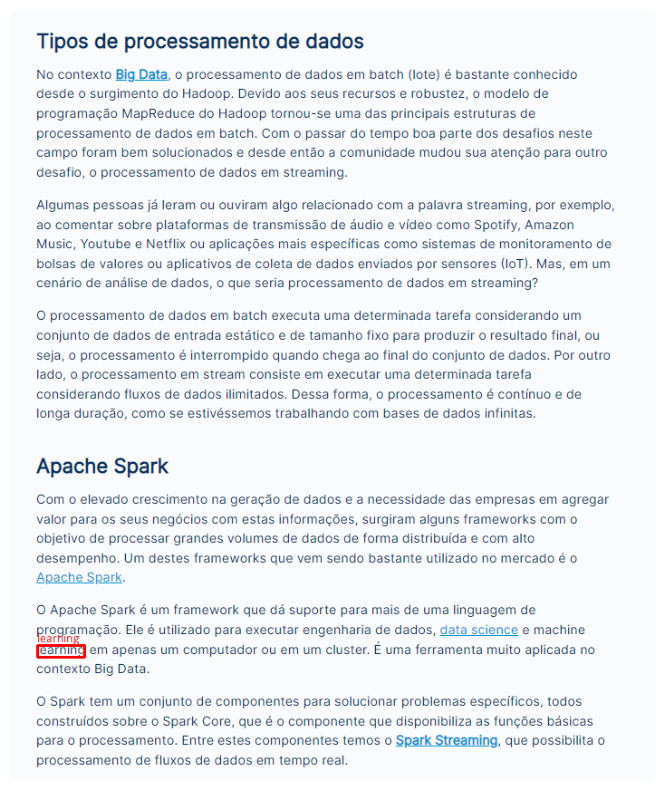



artigo-desbalanceamento.png
Número de ocorrências para learning em artigo-desbalanceamento.png: 1


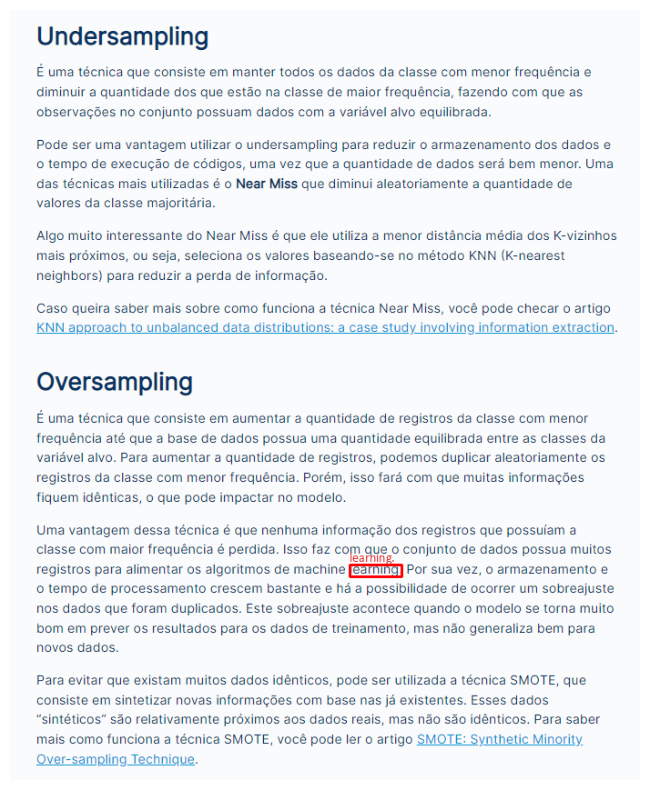

In [58]:
#10 - BUSCA O TERMO DE PESQUISA NAS IMAGENS - v3
termo_pesquisa = 'learning'

for imagem in caminho:
  img = cv2.imread(imagem) #carrega a imagem
  img_original = img.copy() #cria uma cópia da imagem para não escrever em cima da original

  nome_imagem = os.path.split(imagem)[-1] # passa a imagem e acessa a última posição do diretório


  img, numero_ocorrencias = OCR_processa_imagem(img, termo_pesquisa, config_tesseract, min_conf) #usando o OCR_processa_imagem

  if numero_ocorrencias > 0:
    print('===================\n' + str(nome_imagem))  # separação + nome da imagem
    print('Número de ocorrências para {} em {}: {}'.format(termo_pesquisa, nome_imagem, numero_ocorrencias))
    mostrar(img)
    novo_nome_imagem = 'OCR_' + nome_imagem
    nova_imagem = 'images_project/' + str(novo_nome_imagem)
    cv2.imwrite(nova_imagem, img)
    #primeira chaves é para termo de pesquisa e a segunda nome das imagens e a terceira é o numeros de ocorrencias
    print('\n')

